In [15]:
import os
import torch
from torchvision import transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch.nn.functional as F

In [16]:
import kagglehub

# Загрузка датасета
path = kagglehub.dataset_download("dumitrux/architectural-styles-dataset")

print("Path to dataset files:", path)

DATASET_PATH = os.path.join(path, "architectural-styles-dataset")
architectural_styles = sorted([d for d in os.listdir(DATASET_PATH)
                              if os.path.isdir(os.path.join(DATASET_PATH, d))])
class_to_idx = {class_name: idx for idx, class_name in enumerate(architectural_styles)}
print("Количество классов:", len(architectural_styles))
print("Классы:", architectural_styles)

Path to dataset files: /kaggle/input/architectural-styles-dataset
Количество классов: 25
Классы: ['Achaemenid architecture', 'American Foursquare architecture', 'American craftsman style', 'Ancient Egyptian architecture', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture', 'Bauhaus architecture', 'Beaux-Arts architecture', 'Byzantine architecture', 'Chicago school architecture', 'Colonial architecture', 'Deconstructivism', 'Edwardian architecture', 'Georgian architecture', 'Gothic architecture', 'Greek Revival architecture', 'International style', 'Novelty architecture', 'Palladian architecture', 'Postmodern architecture', 'Queen Anne architecture', 'Romanesque architecture', 'Russian Revival architecture', 'Tudor Revival architecture']


Будем использовать датасет [architectural-styles-dataset](https://www.kaggle.com/datasets/dumitrux/architectural-styles-dataset/data?select=architectural-styles-dataset), собранный из изображений,  взятых с Google Images, и набора данных из статьи "*Architectural Style Classification using Multinomial Latent Logistic Regression (ECCV2014)*". Всего содержит 10113 изображений зданий в формате '*.jpg*', каждое из которых относится к одному из 25 класоов, характеризующих различные архитектурный стили.

In [17]:
original_images = []
class ArchitecturalImagesDataset(Dataset):
    """Датасет для загрузки изображений"""

    def __init__(self):
        # Собираем все пути к изображениям
        self.images = []
        self.labels = []

        for class_name in architectural_styles:
          class_dir = os.path.join(DATASET_PATH, class_name)
          class_idx = class_to_idx[class_name]

          for img_name in os.listdir(class_dir):
            if img_name.lower().endswith(('.jpg', '.jpeq')):
              img_path = os.path.join(class_dir, img_name)
              self.images.append(img_path)
              original_images.append(img_path)
              self.labels.append(class_idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        # Загружаем изображение
        image = Image.open(img_path).convert('RGB')

        # Ресайзим изображение
        image = image.resize((224, 224), Image.Resampling.LANCZOS)

        combain_aug = transforms.Compose([
          transforms.RandomHorizontalFlip(p=0.5),
          transforms.RandomVerticalFlip(p=0.2),
          transforms.RandomPerspective(
              distortion_scale=0.15,
              p=0.5,
              interpolation=transforms.InterpolationMode.BILINEAR
          ),
          transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
          transforms.RandomAffine(
              degrees=15,
              translate=(0.1, 0.1),
              scale=(0.9, 1.1)
          ),
          transforms.RandomResizedCrop(
              size=224,
              scale=(0.8, 1.0),
              ratio=(0.75, 1.33),
              interpolation=transforms.InterpolationMode.BILINEAR
          ),
          transforms.GaussianBlur(
              kernel_size=3,
              sigma=(0.1, 2.0)
          ),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
          transforms.RandomErasing(
              p=0.2,
              scale=(0.02, 0.2),
              ratio=(0.3, 3.3)
          )
        ])

        image = combain_aug(image)

        return image, label

В процессе предобработки данных все изображения были приведены к единому размеру: 224x224 *image.resize((224, 224))*. Также были применены следующие аугментации:

1.   *RandomHorizontalFlip* - случайное горизонтальное отображение;
2.   *RandomVerticalFlip* - случайное вертикальное отображение;
3.   *RandomPerspective* - случайное преобразование перспективы;
4.  *ColorJitter* - изменение яркости / насыщенности изображения;
5.  *RandomAffine* - поворот на угол до 15 градусов, случайный сдвиг до 10% и масштабирование в диапазоне от 0.9 до 1.1;
6.  *RandomResizedCrop* - случайная обрезка изображения, с последующим изменением размеров обрезанной части до размеров исходного изображения.
7.  *GaussianBlur* - размытие с помощью случайно выбранного ядра размытия по Гауссу.;
8.  *RandomErasing* - случайное стирание областей.



In [18]:
dataset = ArchitecturalImagesDataset()

Количество объектов класса Achaemenid architecture: 392;
Количество объектов класса American Foursquare architecture: 362;
Количество объектов класса American craftsman style: 364;
Количество объектов класса Ancient Egyptian architecture: 406;
Количество объектов класса Art Deco architecture: 566;
Количество объектов класса Art Nouveau architecture: 615;
Количество объектов класса Baroque architecture: 456;
Количество объектов класса Bauhaus architecture: 315;
Количество объектов класса Beaux-Arts architecture: 424;
Количество объектов класса Byzantine architecture: 313;
Количество объектов класса Chicago school architecture: 278;
Количество объектов класса Colonial architecture: 480;
Количество объектов класса Deconstructivism: 335;
Количество объектов класса Edwardian architecture: 280;
Количество объектов класса Georgian architecture: 381;
Количество объектов класса Gothic architecture: 331;
Количество объектов класса Greek Revival architecture: 523;
Количество объектов класса Inter

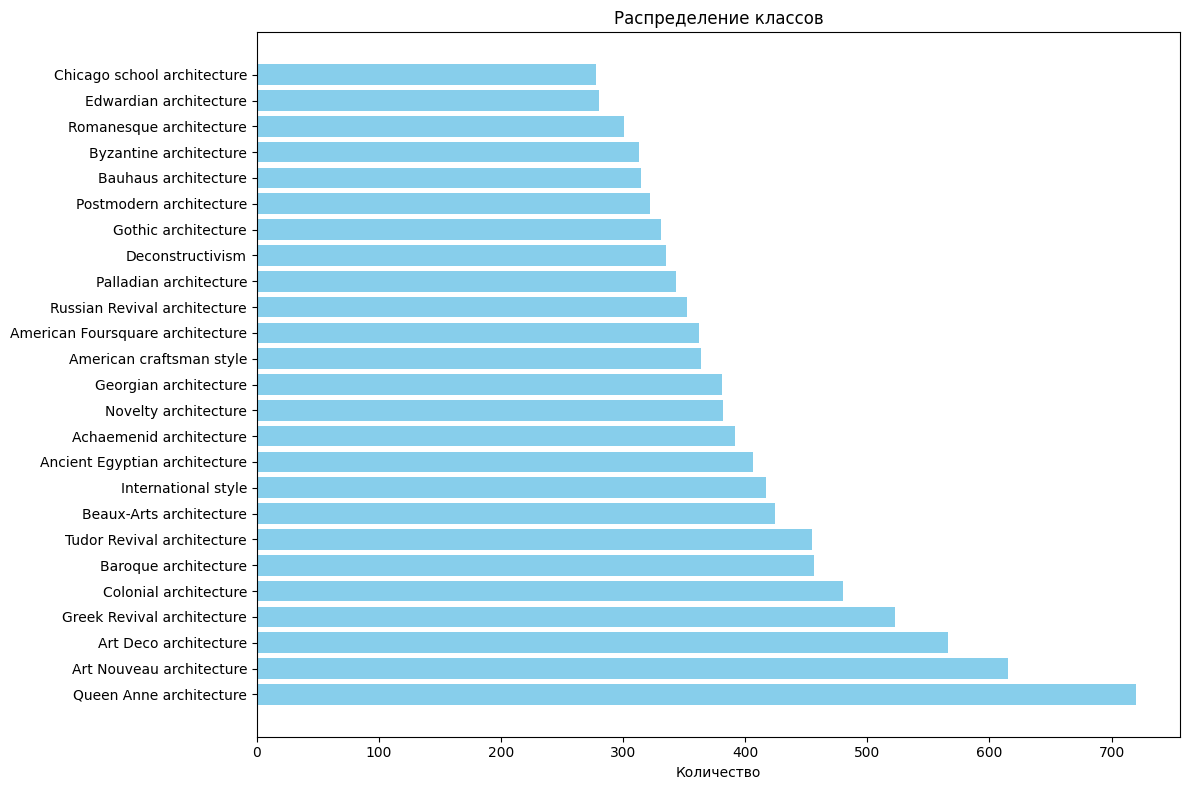

In [19]:
value_counts = dict()
for key, value in class_to_idx.items():
  count = dataset.labels.count(value)
  value_counts[key] = count
  print(f"Количество объектов класса {key}: {count};")

# Сортируем данные по убыванию
sorted_data = dict(sorted(value_counts.items(), key=lambda x: x[1], reverse=True))

# Создаем фигуру
plt.figure(figsize=(12, 8))
plt.barh(list(sorted_data.keys()), list(sorted_data.values()), color='skyblue')
plt.xlabel('Количество')
plt.title('Распределение классов')
plt.tight_layout()
plt.show()

Данные демонстрируют значительный дисбаланс в классах. Максимальное значение: Queen Anne architecture: (720), – в 2,5 раза больше минимального - Chicago school architecture: (278).


In [6]:
def show_single_augmentation(original_img, augmented_img, title="Аугментация"):
    """Визуализирует оригинальное и аугментированное изображение рядом."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    # Увеличиваем изображения (сохраняем исходную логику)
    resize_transform = transforms.Resize((128, 128), antialias=True)

    # Оригинальное изображение (автоматическая конвертация в тензор если нужно)
    orig_tensor = transforms.functional.to_tensor(original_img) if not isinstance(original_img, torch.Tensor) else original_img
    orig_resized = resize_transform(orig_tensor)
    orig_np = orig_resized.numpy().transpose(1, 2, 0)
    orig_np = np.clip(orig_np, 0, 1)
    ax1.imshow(orig_np)
    ax1.set_title("Оригинал")
    ax1.axis('off')

    # Аугментированное изображение (автоматическая конвертация в тензор если нужно)
    aug_tensor = transforms.functional.to_tensor(augmented_img) if not isinstance(augmented_img, torch.Tensor) else augmented_img
    aug_resized = resize_transform(aug_tensor)
    aug_np = aug_resized.numpy().transpose(1, 2, 0)
    aug_np = np.clip(aug_np, 0, 1)
    ax2.imshow(aug_np)
    ax2.set_title(title)
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

Визуализация исходных изображений и применённых аугментаций


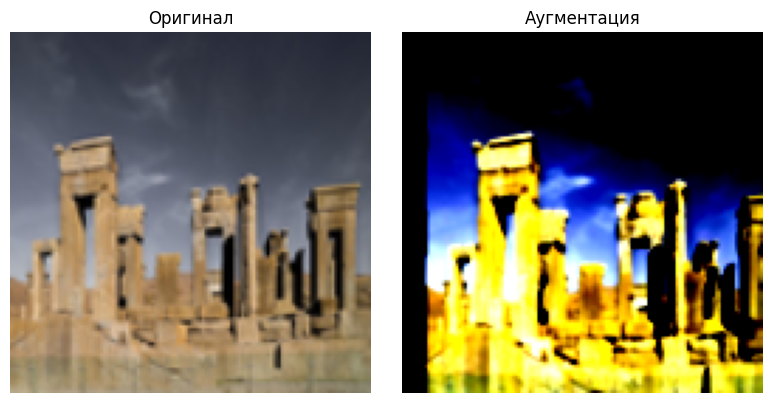

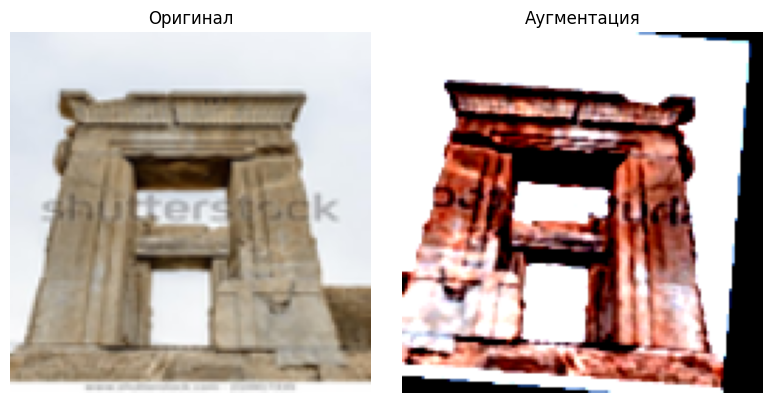

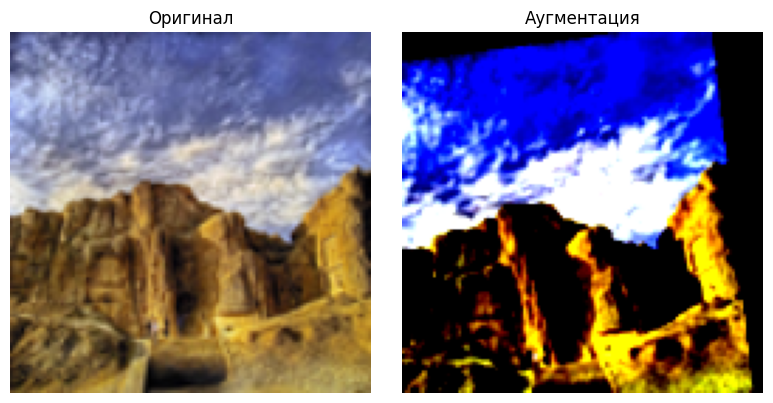

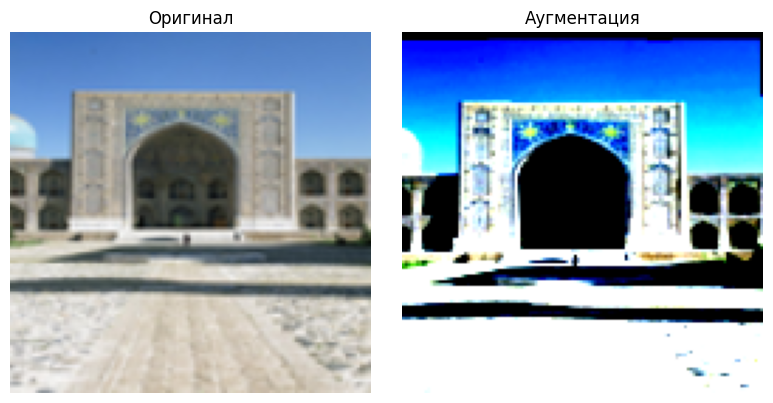

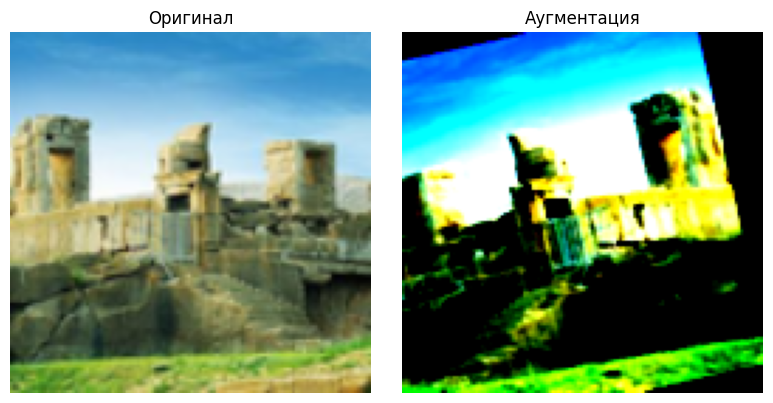

In [42]:
# Визуализируем первые 5 изображений и их аугментации
print('Визуализация исходных изображений и применённых аугментаций')
for i in range(5):
  img = original_images[i]
  img = Image.open(img).convert('RGB')
  img = img.resize((100, 100), Image.Resampling.LANCZOS)
  combined_img, label1 = dataset[i]
  show_single_augmentation(img, combined_img, title="Аугментация")

Разделение на тестовую и тренировачную выборки

Train samples: 8090
Test samples: 2023
Train sample (with augmentation):


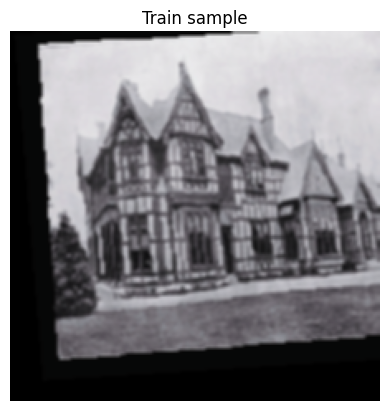

Test sample (no augmentation):


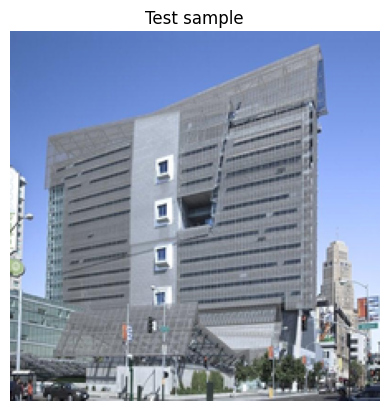

In [21]:
class SplitArchitecturalImagesDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        img = img.resize((224, 224), Image.Resampling.LANCZOS)
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

image_paths = []
labels = []

for class_name in architectural_styles:
    class_dir = os.path.join(DATASET_PATH, class_name)
    for img_name in os.listdir(class_dir):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(class_dir, img_name)
            image_paths.append(img_path)
            labels.append(class_to_idx[class_name])

# Разделение данных
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Трансформации
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomPerspective(
        distortion_scale=0.15,
        p=0.5,
        interpolation=transforms.InterpolationMode.BILINEAR
        ),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomAffine(
        degrees=15,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1)
        ),
    transforms.RandomResizedCrop(
        size=224,
        scale=(0.8, 1.0),
        ratio=(0.75, 1.33),
        interpolation=transforms.InterpolationMode.BILINEAR
        ),
    transforms.GaussianBlur(
        kernel_size=3,
        sigma=(0.1, 2.0)
        ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(
        p=0.2,
        scale=(0.02, 0.2),
        ratio=(0.3, 3.3)
        )
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Создание датасетов
train_dataset = SplitArchitecturalImagesDataset(train_paths, train_labels, train_transform)
test_dataset = SplitArchitecturalImagesDataset(test_paths, test_labels, test_transform)

# Проверка
print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Визуализация
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

print("Train sample (with augmentation):")
imshow(train_dataset[0][0], "Train sample")

print("Test sample (no augmentation):")
imshow(test_dataset[0][0], "Test sample")

Функция обучения модели

Для борьбы с дисбалансом классов будем использовать в качестве функции потерь FocalLoss, которая уменьшает вес хорошо классифицированных примеров, а также добавим F1-score в качестве метрики при оценке модели, так как он также устойчив к дисбалансу классов, в отличие от accuracy.

In [22]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return loss.mean()

In [36]:
def run_epoch(model, data_loader, criterion, optimizer=None, device='cpu', is_test=False):
    if is_test:
        model.eval()
    else:
        model.train()

    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.set_grad_enabled(not is_test):
        for data, target in tqdm(data_loader):
            data, target = data.to(device), target.to(device)

            if optimizer:
                optimizer.zero_grad()

            output = model(data)
            loss = criterion(output, target)

            if not is_test:
                loss.backward()
                optimizer.step()

            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

            if is_test:
                all_preds.extend(pred.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

    metrics = {
        'loss': total_loss / len(data_loader),
        'accuracy': correct / total,
    }

    if is_test:
        metrics['preds'] = all_preds
        metrics['targets'] = all_targets
        metrics['f1'] = f1_score(all_targets, all_preds, average='weighted')

    return metrics

def train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device='cpu', optimizer=None):
    criterion = FocalLoss()  # Используем Focal Loss вместо CrossEntropy
    optimizer = optimizer

    history = {
        'train_losses': [],
        'train_accs': [],
        'test_losses': [],
        'test_accs': [],
        'test_f1s': []
    }

    for epoch in range(epochs):
        train_metrics = run_epoch(model, train_loader, criterion, optimizer, device)
        test_metrics = run_epoch(model, test_loader, criterion, None, device, is_test=True)

        history['train_losses'].append(train_metrics['loss'])
        history['train_accs'].append(train_metrics['accuracy'])
        history['test_losses'].append(test_metrics['loss'])
        history['test_accs'].append(test_metrics['accuracy'])
        history['test_f1s'].append(test_metrics['f1'])

        print(f'Epoch {epoch+1}/{epochs}:')
        print(f"Train Loss: {train_metrics['loss']:.4f} | Acc: {train_metrics['accuracy']:.4f}")
        print(f"Test Loss: {test_metrics['loss']:.4f} | Acc: {test_metrics['accuracy']:.4f} | F1: {test_metrics['f1']:.4f}")
        print('-' * 50)

    print("\nClassification Report:")
    print(classification_report(
        test_metrics['targets'],
        test_metrics['preds'],
        target_names=architectural_styles
    ))

    return history

Визуализация кривой обучения

In [24]:
def plot_training_history(history):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['test_losses'], label='Test Loss')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accs'], label='Train Acc')
    ax2.plot(history['test_accs'], label='Test Acc')
    ax2.set_title('Accuracy')
    ax2.legend()

    ax3.plot(history['test_f1s'], label='Test F1', color='red')
    ax3.set_title('F1-score')
    ax3.legend()

    plt.tight_layout()
    plt.show()

Построение матрицы ошибок

In [25]:
def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    device = next(model.parameters()).device
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Прогноз')
    plt.ylabel('Действительность')
    plt.title('Confusion Matrix')
    plt.show()

Подсчет количества параметров модели

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Сохранение, загрузка модели

In [27]:
def save_model(model, path):
    torch.save(model.state_dict(), path)


def load_model(model, path):
    model.load_state_dict(torch.load(path))
    return model

Загрузка и дообучение модели Resnet

In [32]:
def learning_resnet_model(num_classes, unfreeze_layers=4, pretrained=True):
    model = models.resnet34(pretrained=pretrained)

    total_layers = len(list(model.children()))
    for idx, (name, child) in enumerate(model.named_children()):
        if idx < total_layers - unfreeze_layers:
            for param in child.parameters():
                param.requires_grad = False
        else:
            for param in child.parameters():
                param.requires_grad = True

    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Linear(512, num_classes)
    )

    for m in model.fc.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    return model

cuda
ResNet count parameters: 20213273


100%|██████████| 64/64 [00:34<00:00,  1.85it/s]


Epoch 1/15:
Train Loss: 0.5056 | Acc: 0.3199
Test Loss: 0.2757 | Acc: 0.5408 | F1: 0.5260
--------------------------------------------------


100%|██████████| 64/64 [00:30<00:00,  2.07it/s]


Epoch 2/15:
Train Loss: 0.3228 | Acc: 0.4811
Test Loss: 0.2429 | Acc: 0.5863 | F1: 0.5700
--------------------------------------------------


100%|██████████| 64/64 [00:29<00:00,  2.20it/s]


Epoch 3/15:
Train Loss: 0.2705 | Acc: 0.5415
Test Loss: 0.2137 | Acc: 0.6218 | F1: 0.6177
--------------------------------------------------


100%|██████████| 64/64 [00:29<00:00,  2.14it/s]


Epoch 4/15:
Train Loss: 0.2315 | Acc: 0.5811
Test Loss: 0.2304 | Acc: 0.5922 | F1: 0.5853
--------------------------------------------------


100%|██████████| 64/64 [00:29<00:00,  2.19it/s]


Epoch 5/15:
Train Loss: 0.2052 | Acc: 0.6177
Test Loss: 0.2236 | Acc: 0.6105 | F1: 0.6000
--------------------------------------------------


100%|██████████| 64/64 [00:29<00:00,  2.14it/s]


Epoch 6/15:
Train Loss: 0.1850 | Acc: 0.6436
Test Loss: 0.2008 | Acc: 0.6391 | F1: 0.6350
--------------------------------------------------


100%|██████████| 64/64 [00:29<00:00,  2.19it/s]


Epoch 7/15:
Train Loss: 0.1722 | Acc: 0.6642
Test Loss: 0.2210 | Acc: 0.6283 | F1: 0.6275
--------------------------------------------------


100%|██████████| 64/64 [00:29<00:00,  2.17it/s]


Epoch 8/15:
Train Loss: 0.1571 | Acc: 0.6850
Test Loss: 0.2063 | Acc: 0.6510 | F1: 0.6541
--------------------------------------------------


100%|██████████| 64/64 [00:29<00:00,  2.19it/s]


Epoch 9/15:
Train Loss: 0.1428 | Acc: 0.7085
Test Loss: 0.2025 | Acc: 0.6441 | F1: 0.6497
--------------------------------------------------


100%|██████████| 64/64 [00:29<00:00,  2.20it/s]


Epoch 10/15:
Train Loss: 0.1328 | Acc: 0.7171
Test Loss: 0.2059 | Acc: 0.6653 | F1: 0.6640
--------------------------------------------------


100%|██████████| 64/64 [00:29<00:00,  2.14it/s]


Epoch 11/15:
Train Loss: 0.1247 | Acc: 0.7394
Test Loss: 0.2158 | Acc: 0.6540 | F1: 0.6548
--------------------------------------------------


100%|██████████| 64/64 [00:29<00:00,  2.20it/s]


Epoch 12/15:
Train Loss: 0.1149 | Acc: 0.7533
Test Loss: 0.2117 | Acc: 0.6673 | F1: 0.6684
--------------------------------------------------


100%|██████████| 64/64 [00:30<00:00,  2.09it/s]


Epoch 13/15:
Train Loss: 0.1110 | Acc: 0.7640
Test Loss: 0.2179 | Acc: 0.6644 | F1: 0.6607
--------------------------------------------------


100%|██████████| 64/64 [00:30<00:00,  2.11it/s]


Epoch 14/15:
Train Loss: 0.1048 | Acc: 0.7665
Test Loss: 0.2255 | Acc: 0.6451 | F1: 0.6438
--------------------------------------------------


100%|██████████| 64/64 [00:29<00:00,  2.17it/s]


Epoch 15/15:
Train Loss: 0.0951 | Acc: 0.7842
Test Loss: 0.2224 | Acc: 0.6678 | F1: 0.6664
--------------------------------------------------

Classification Report:
                                  precision    recall  f1-score   support

         Achaemenid architecture       0.96      0.81      0.88        79
American Foursquare architecture       0.71      0.68      0.70        72
        American craftsman style       0.60      0.51      0.55        73
   Ancient Egyptian architecture       0.94      0.93      0.93        81
           Art Deco architecture       0.63      0.70      0.66       113
        Art Nouveau architecture       0.81      0.67      0.73       123
            Baroque architecture       0.63      0.70      0.66        91
            Bauhaus architecture       0.66      0.65      0.66        63
         Beaux-Arts architecture       0.49      0.49      0.49        85
          Byzantine architecture       0.59      0.73      0.65        63
     Chicago school

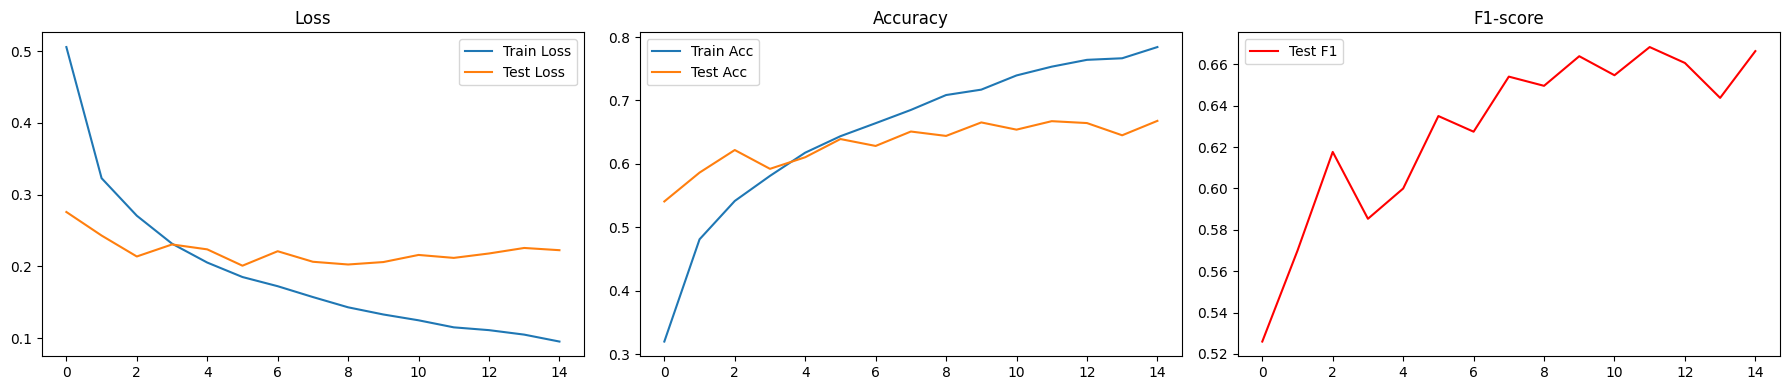

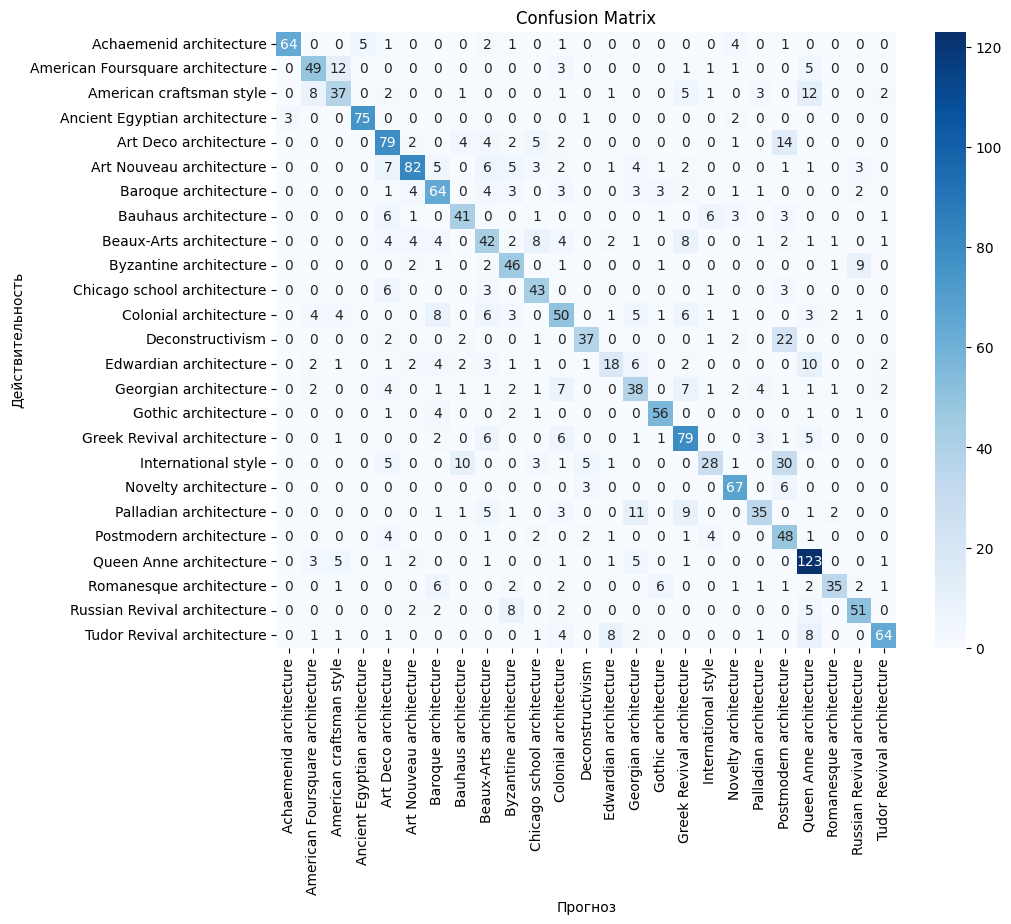

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
num_classes = len(architectural_styles)

resnet_model = learning_resnet_model(num_classes=25, unfreeze_layers=4).to(device)
print(f"ResNet count parameters: {count_parameters(resnet_model)}")

params_group = []
params_group.append({'params': [p for n, p in resnet_model.named_parameters()
                              if not p.requires_grad]})

params_group.append({'params': [p for n, p in resnet_model.named_parameters()
                              if p.requires_grad and 'fc' not in n],
                   'lr': 1e-4})

params_group.append({'params': resnet_model.fc.parameters(),
                   'lr': 1e-3})

optimizer = torch.optim.AdamW(params_group, weight_decay=1e-5)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

resnet_history = train_model(
        model=resnet_model,
        train_loader=train_loader,
        test_loader=test_loader,
        epochs=15,
        lr=0.001,
        device=device,
        optimizer=optimizer
    )

plot_training_history(resnet_history)

save_model(resnet_model, 'resnet_model.pth')
plot_confusion_matrix(resnet_model, test_loader, architectural_styles)

Загрузка и дообучение модели EfficientNet-B0

In [39]:
def initialize_effnet(num_classes):
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

    for param in model.parameters():
        param.requires_grad = False

    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Linear(512, num_classes)
    )

    for param in model.features[-3:].parameters():
        param.requires_grad = True

    return model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


cuda


100%|██████████| 20.5M/20.5M [00:00<00:00, 95.4MB/s]


EfficientNet-B0 count parameters: 3825461


100%|██████████| 64/64 [00:29<00:00,  2.20it/s]


Epoch 1/15:
Train Loss: 0.4115 | Acc: 0.3781
Test Loss: 0.3270 | Acc: 0.4656 | F1: 0.4468
--------------------------------------------------


100%|██████████| 64/64 [00:28<00:00,  2.28it/s]


Epoch 2/15:
Train Loss: 0.2877 | Acc: 0.5062
Test Loss: 0.2817 | Acc: 0.5136 | F1: 0.4971
--------------------------------------------------


100%|██████████| 64/64 [00:28<00:00,  2.25it/s]


Epoch 3/15:
Train Loss: 0.2439 | Acc: 0.5666
Test Loss: 0.2512 | Acc: 0.5640 | F1: 0.5571
--------------------------------------------------


100%|██████████| 64/64 [00:28<00:00,  2.21it/s]


Epoch 4/15:
Train Loss: 0.2160 | Acc: 0.5921
Test Loss: 0.2465 | Acc: 0.5576 | F1: 0.5433
--------------------------------------------------


100%|██████████| 64/64 [00:28<00:00,  2.25it/s]


Epoch 5/15:
Train Loss: 0.1991 | Acc: 0.6174
Test Loss: 0.2434 | Acc: 0.5591 | F1: 0.5482
--------------------------------------------------


100%|██████████| 64/64 [00:29<00:00,  2.16it/s]


Epoch 6/15:
Train Loss: 0.1826 | Acc: 0.6386
Test Loss: 0.2601 | Acc: 0.5586 | F1: 0.5437
--------------------------------------------------


100%|██████████| 64/64 [00:28<00:00,  2.27it/s]


Epoch 7/15:
Train Loss: 0.1653 | Acc: 0.6638
Test Loss: 0.2370 | Acc: 0.5912 | F1: 0.5790
--------------------------------------------------


100%|██████████| 64/64 [00:29<00:00,  2.19it/s]


Epoch 8/15:
Train Loss: 0.1545 | Acc: 0.6718
Test Loss: 0.2370 | Acc: 0.5937 | F1: 0.5785
--------------------------------------------------


100%|██████████| 64/64 [00:28<00:00,  2.24it/s]


Epoch 9/15:
Train Loss: 0.1470 | Acc: 0.6894
Test Loss: 0.2372 | Acc: 0.5966 | F1: 0.5889
--------------------------------------------------


100%|██████████| 64/64 [00:28<00:00,  2.26it/s]


Epoch 10/15:
Train Loss: 0.1372 | Acc: 0.7015
Test Loss: 0.2282 | Acc: 0.6026 | F1: 0.5943
--------------------------------------------------


100%|██████████| 64/64 [00:28<00:00,  2.25it/s]


Epoch 11/15:
Train Loss: 0.1293 | Acc: 0.7173
Test Loss: 0.2166 | Acc: 0.6253 | F1: 0.6233
--------------------------------------------------


100%|██████████| 64/64 [00:28<00:00,  2.21it/s]


Epoch 12/15:
Train Loss: 0.1203 | Acc: 0.7284
Test Loss: 0.2181 | Acc: 0.6115 | F1: 0.6057
--------------------------------------------------


100%|██████████| 64/64 [00:28<00:00,  2.26it/s]


Epoch 13/15:
Train Loss: 0.1086 | Acc: 0.7485
Test Loss: 0.2390 | Acc: 0.5887 | F1: 0.5852
--------------------------------------------------


100%|██████████| 64/64 [00:28<00:00,  2.27it/s]


Epoch 14/15:
Train Loss: 0.1040 | Acc: 0.7593
Test Loss: 0.2175 | Acc: 0.6228 | F1: 0.6167
--------------------------------------------------


100%|██████████| 64/64 [00:28<00:00,  2.22it/s]


Epoch 15/15:
Train Loss: 0.0978 | Acc: 0.7658
Test Loss: 0.2110 | Acc: 0.6209 | F1: 0.6108
--------------------------------------------------

Classification Report:
                                  precision    recall  f1-score   support

         Achaemenid architecture       0.92      0.77      0.84        79
American Foursquare architecture       0.60      0.17      0.26        72
        American craftsman style       0.35      0.75      0.48        73
   Ancient Egyptian architecture       0.86      0.98      0.91        81
           Art Deco architecture       0.56      0.70      0.62       113
        Art Nouveau architecture       0.67      0.60      0.63       123
            Baroque architecture       0.60      0.58      0.59        91
            Bauhaus architecture       0.56      0.71      0.62        63
         Beaux-Arts architecture       0.55      0.31      0.39        85
          Byzantine architecture       0.59      0.70      0.64        63
     Chicago school

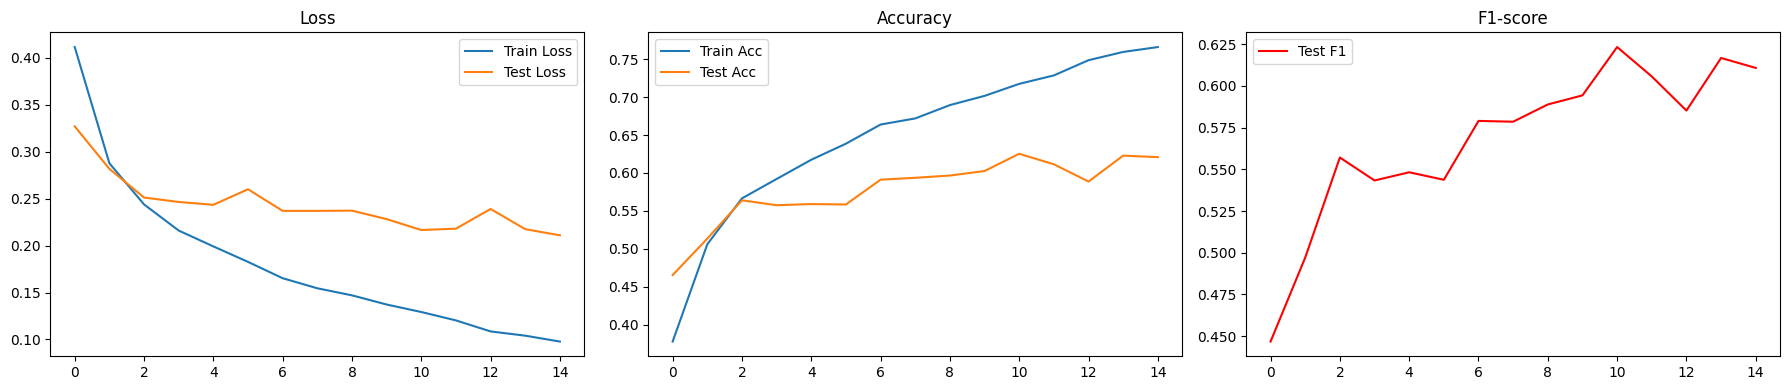

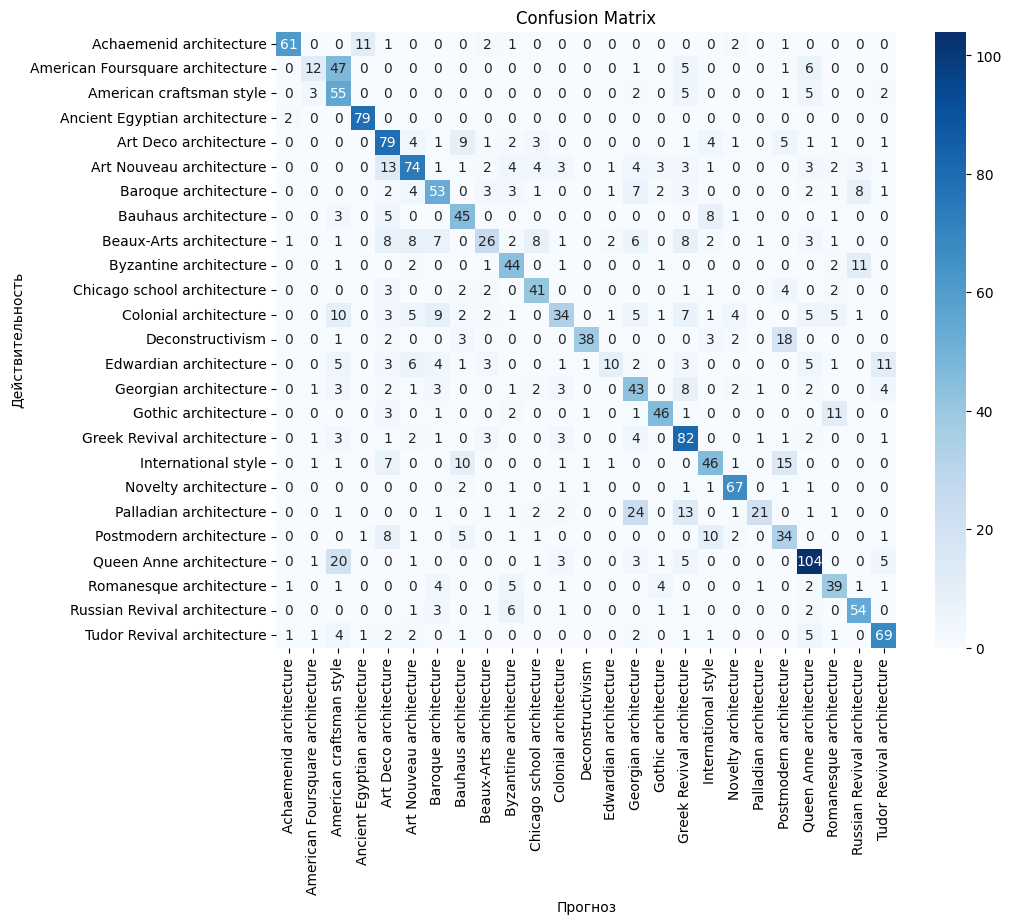

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
num_classes = len(architectural_styles)

model_effnet = initialize_effnet(num_classes).to(device)
print(f"EfficientNet-B0 count parameters: {count_parameters(model_effnet)}")

optimizer = optim.AdamW([
    {'params': model_effnet.features.parameters(), 'lr': 1e-4},
    {'params': model_effnet.classifier.parameters(), 'lr': 1e-3}
], weight_decay=1e-5)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

effnet_history = train_model(
        model=model_effnet,
        train_loader=train_loader,
        test_loader=test_loader,
        epochs=15,
        lr=0.001,
        device=device,
        optimizer=optimizer
    )

plot_training_history(effnet_history)

save_model(model_effnet, 'model_effnet.pth')
plot_confusion_matrix(model_effnet, test_loader, architectural_styles)